In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from IPython.display import set_matplotlib_formats

# 레티나 디스플레이 설정
set_matplotlib_formats('retina')

df = pd.read_csv('../PROCESSED/merge_df.csv')
# 병합 데이터 불러오기

import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False


In [ ]:
df = df.dropna()

---
# EDA

## 변수 생성 및 EDA를 위한 데이터프레임 생성

- 거래 날짜, 월, 주차 열 생성
- 고객,주차별 거래 횟수, 거래 여부 데이터 프레임 생성

In [ ]:
df['거래날짜'] = pd.to_datetime(df['거래날짜'])
df['거래월'] = df['거래날짜'].dt.month
df['거래주차'] = df['거래날짜'].dt.strftime('%U').astype(int)
# 거래 날짜 관련 열 생성

In [ ]:
week_transaction_count = df.groupby(['고객ID','거래주차'])['거래ID'].count().unstack().fillna(0)
week_transaction_binary = (week_transaction_count>0).astype('int')
# 주차별 거래 횟수, 거래 여부 데이터 프레임 생성

In [ ]:
def calculate_discounted_price(row):
    if row['쿠폰상태'] == 'Used':
        return (row['평균금액'] * row['수량']) * (1 - (row['할인율'] / 100))
    else:
        return row['평균금액'] * row['수량']

before_profit = df.apply(calculate_discounted_price,axis=1)
# 할인된 지불금액
net_profit = (before_profit - df['배송료']) * (1-df['GST'])
# 할인 후 금액 - 배송비 - 세금 = 순수익
df['순수익']=net_profit
# 거래별 순수익 측정
month_profit = df.groupby(['거래월','고객지역'])['순수익'].sum().unstack()
# 순수익 열 생성

In [ ]:
def remove_outliers_by_percentile(data):
    lower_bound = np.percentile(data, 5)
    upper_bound = np.percentile(data, 95)
    return data[(data >= lower_bound) & (data <= upper_bound)]

wtc = week_transaction_count.sum(axis=1)
wtc_r= remove_outliers_by_percentile(wtc)
#상하위 5%씩 절삭

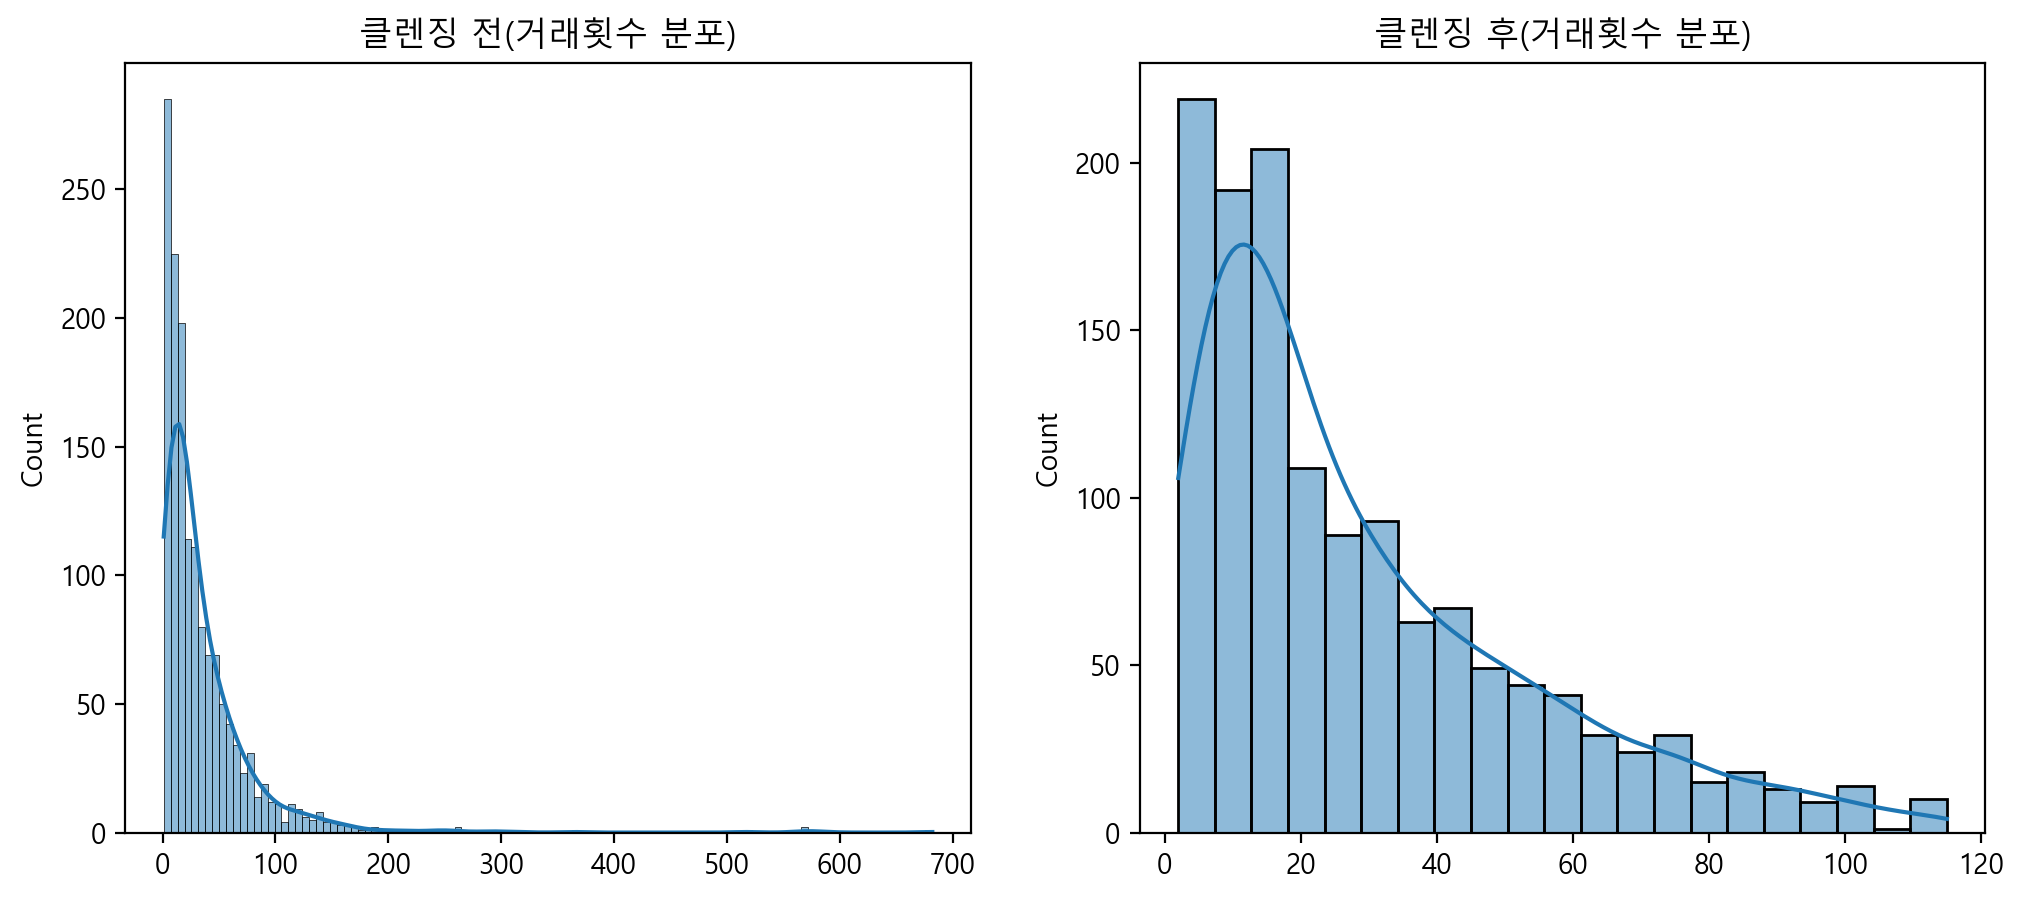

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(wtc, ax=axs[0], kde=True)
axs[0].set_title("클렌징 전(거래횟수 분포)")
sns.histplot(wtc_r, ax=axs[1], kde=True)
axs[1].set_title("클렌징 후(거래횟수 분포)")
plt.show()
# 거래 횟수는 보통 1년 동안 대부분 0~30회 수행하는 것으로 볼 수 있음.
# 특정 고객들은 수백회가 넘는 거래 빈도를 보임.

In [ ]:
wbs = week_transaction_binary.sum(axis=1)
wbc = pd.DataFrame(wbs.value_counts())
wbc = wbc.sort_index()

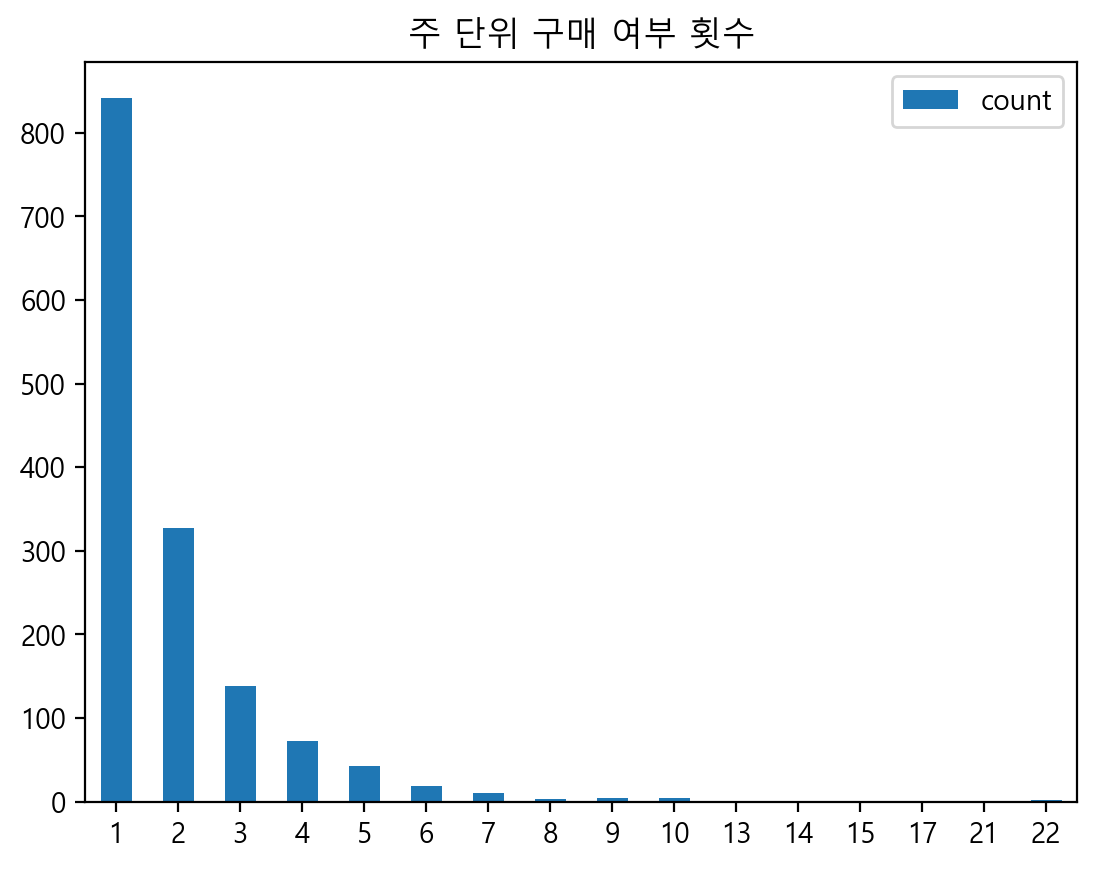

In [ ]:
wbc.plot(kind='bar')
plt.title('주 단위 구매 여부 횟수')
plt.xticks(rotation=0)
plt.show()
# 대부분 1주 안에 여러 번 구매하고 이탈하는 것으로 볼 수 있음.
# 재방문 빈도가 매우 낮은 문제를 식별함

In [ ]:
one_visiter = week_transaction_binary[week_transaction_binary.sum(axis=1)==1].index.to_list()
one_visiter_df = df[df['고객ID'].isin(one_visiter)]
# 주 단위 재방문이 없던 고객 데이터프레임
over_visiter_df = df[~df['고객ID'].isin(one_visiter)]
# 2주 이상 재방문 한 고객 데이터프레임

In [ ]:
onep=remove_outliers_by_percentile(one_visiter_df['순수익'])
ovep=remove_outliers_by_percentile(over_visiter_df['순수익'])
# 순수익 특이치 클렌징
print('재방문 없던 고객 순수익 평균      :',np.round(onep.mean()))
print('2주 이상 재방문한 고객 순수익 평균:',np.round(ovep.mean()))
print('-'*50)
print('재방문 없던 고객 순수익 총계      :',np.round(onep.sum()))
print('2주 이상 재방문한 고객 순수익 총계:',np.round(ovep.sum()))
print('-'*50)
print('재방문 없던 고객 총 거래 횟수      :',onep.shape[0])
print('2주 이상 재방문한 고객 총 거래 횟수:',ovep.shape[0])
print('-'*50)
print('재방문 없던 고객의 수      :',len(one_visiter))
print('2주 이상 재방문한 고객의 수:',len(over_visiter_df['고객ID'].unique()))
print('-'*50)
print('재방문 없던 고객의 평균 거래 빈도      :',np.round(one_visiter_df.groupby(['고객ID'])['거래ID'].count().mean()))
print('2주 이상 재방문한 고객의 평균 거래 빈도:',np.round(over_visiter_df.groupby(['고객ID'])['거래ID'].count().mean()))

# 재방문하는 고객은 거래 횟수(총,평균 모두)에서 큰 차이를 보이며 이 차이가 특히 순수익의 차이를 야기시키는 것으로 보임.
# 고객의 수와 평균 순수익에는 큰 차이가 존재한다고 보기 어려움.

재방문 없던 고객 순수익 평균      : 53.0
2주 이상 재방문한 고객 순수익 평균: 49.0
--------------------------------------------------
재방문 없던 고객 순수익 총계      : 847781.0
2주 이상 재방문한 고객 순수익 총계: 1539266.0
--------------------------------------------------
재방문 없던 고객 총 거래 횟수      : 16042
2주 이상 재방문한 고객 총 거래 횟수: 31337
--------------------------------------------------
재방문 없던 고객의 수      : 842
2주 이상 재방문한 고객의 수: 626
--------------------------------------------------
재방문 없던 고객의 평균 거래 빈도      : 21.0
2주 이상 재방문한 고객의 평균 거래 빈도: 56.0


# 비즈니스 문제 도출
- 재방문 없이 1주 안에 집중적인 구매 후 이탈하는 고객이 전체 고객의 약 57.3%
- 2주 이상 재방문한 고객의 평균 거래 횟수는 그렇지 않은 고객에 비해 약 266% 더 많음.
- 따라서 재방문 고객을 확보한다면 이전 대비 더 높은 구매 횟수 성과를 달성하는 데 도움이 될 가능성이 높음.

# 분석 목표
- 고객 별 특징을 포함하여 고객군 별 페르소나를 정의한 다음, 각 고객군별 최적의 리텐션 전략을 제시
- 일회성 구매 고객과 재방문 고객의 구매 패턴을 분석하여 구매 여정 간 차이가 있는지 확인한 다음, 해당 여정이 식별된 고객을 재방문 고객으로 유도할 수 있는 전략 제시

In [ ]:
df.to_csv('../PROCESSED/processed_df.csv',index=False)